# Predicting Spotify Artist Collaborations Using GAT

Laura Wu
laurawjr@stanford.edu

Jay Yu
 jyu01@stanford.edu

Jiacheng Hu
jchu0822@stanford.edu

## Download Dataset from Kaggle

**Spotify Artist Feature Collaboration Network**


Link: https://www.kaggle.com/datasets/jfreyberg/spotify-artist-feature-collaboration-network?select=nodes.csv

In [1]:
!pip install kaggle
!mkdir kaggle
# Assume API Key
!echo '{"username":"fishylosopher","key":"fc468f8d4488e371ee3330e48377bbaa"}' > kaggle.json
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jfreyberg/spotify-artist-feature-collaboration-network
! unzip spotify-artist-feature-collaboration-network.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open spotify-artist-feature-collaboration-network.zip, spotify-artist-feature-collaboration-network.zip.zip or spotify-artist-feature-collaboration-network.zip.ZIP.


## Transform Kaggle Dataset into PyG
TODO:

In [2]:
# Install PyG
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
!pip install torch-geometric
!pip install pandas
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 58.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 44.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=32ae42246f3285a7752646312c0e59be9b868a51db8e0d8cf13d8e8696c89c7c
  Stored in directory: /root/.cache/pip/wheels/31/b2/8c/9b4bb72a4384eabd1ffeab2b7ead692c9165e35711f8a9dc72
Successfully 

In [3]:
import torch_geometric
import pandas as pd
import numpy as np
torch_geometric.__version__

'2.2.0'

In [4]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.7 MB/s eta 0:00:00


In [5]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def generate_embeddings():
    edge_df = pd.read_csv('edges.csv')
    node_df = pd.read_csv('nodes.csv')
    node_df = node_df.drop_duplicates(['spotify_id']).reset_index(drop=True)
    edge_df = edge_df.drop_duplicates().reset_index(drop=True)
    
    with open('int_id.json') as int_json:
        int_id_dict = json.load(int_json)
    with open('genre_id.json') as genre_json:
        genre_id_dict = json.load(genre_json)
    with open('chart_is.json') as chart_json:
        chart_hit_dict = json.load(chart_json)
    
    genres = []
    for x in genre_id_dict:
        genres.append(x.strip("'").strip('\"'))
        
    encoding_dict = {}
    for x in genres:
        encoding_dict[x] = encode_text(x)
        
    def hit_to_int(hit):
        ints = ''
        for i in hit:
            if i.isdigit():
                ints += i
        return int(ints)
    
    nodes = []
    for i in range(len(node_df)):
        node = node_df.loc[i]
        followers = node['followers']
        if followers is None:
            followers = 0
        pop = node['popularity']
        if pop is None:
            pop = 0
        follower_tensor = torch.Tensor([followers])
        pop_tensor = torch.Tensor([pop])
        genre_tensor = torch.zeros_like(torch.Tensor(768))
        hit_tensor = torch.zeros_like(torch.Tensor(71))
        genres = node['genres'].strip("][").split(', ')
        for genre in genres:
            genre = genre.strip("'").strip('\"')
            genre_tensor += encoding_dict[genre].squeeze()
        hits = str(node_df.loc[i]['chart_hits']).strip('][').split(', ')
        for hit in hits:
            if hit == 'nan':
                continue
            country = hit[1:3]
            hit_tensor[chart_hit_dict[country]] = hit_to_int(hit)
        node_tensor = torch.cat((follower_tensor, pop_tensor, genre_tensor, hit_tensor))
        nodes.append(node_tensor.unsqueeze(0))
    
    nodes_tensor = torch.cat(tuple(nodes), dim=0)
    
    edges = []
    for i in range(len(edge_df)):
        edge = edge_df.loc[i]
        if edge['id_0'] in int_id_dict and edge['id_1'] in int_id_dict:
            edges.append([int_id_dict[edge['id_0']], int_id_dict[edge['id_1']]])
            edges.append([int_id_dict[edge['id_1']], int_id_dict[edge['id_0']]])
    edges = torch.Tensor(edges)
    return torch.nan_to_num(nodes_tensor), edges.T

In [7]:
import json
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.utils import negative_sampling

nodes, edges = generate_embeddings()
#nodes = torch.tensor(nodes,device='cuda')
#edges = torch.tensor(edges,device='cuda')

In [8]:
num_edges = edges.size()[1]
split = int(num_edges*0.8)
train_edges = edges[:,:split]
test_edges = edges[:,split:]

In [9]:
from torch_geometric.data import Data
#data = Data(x=nodes, edge_index=edges)
full_data = Data(x=nodes, edge_index=edges.long())
train_data = Data(x=nodes, edge_index=train_edges.long())
test_data = Data(x=nodes, edge_index=test_edges.long())

## GNN Module Stack
TODO: Copy from Colab 4

In [10]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        # Init GAT Conv Layers
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        self.convs.append(GATConv(input_dim, hidden_dim))
        for i in range(args.num_layers - 1):
            self.convs.append(GATConv(hidden_dim, hidden_dim))
        self.dropout = args.dropout

        # Post Message Passing Layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout
        self.num_layers = args.num_layers
        self.emb = emb

    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)
            

        # Post Message Passing
        x = self.post_mp(x)
        return x if self.emb == True else F.log_softmax(x, dim=1)
        
    def loss(self, pred, label):
        return F.nll_loss(pred, label)   

## Prediction

In [11]:
class ColabPrediction(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(ColabPrediction, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_channels, hidden_channels))
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_channels, hidden_channels))
        self.layers.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j
        for l in self.layers[:-1]:
            x = l(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)
        return torch.sigmoid(self.layers[-1](x))

In [12]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

## Training
TODO

In [21]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy
from torch_geometric.loader import DataLoader

import torch_geometric.nn as pyg_nn
from torch_geometric.utils import negative_sampling



import torch.optim as optim
from sklearn.metrics import roc_auc_score


# Define the training function
def train(model, data, predictor):
    
    model.train()
    predictor.train()
    losses = []
    #load in a batch of edges at a time (set to 64)
    for batch in DataLoader(range(data.edge_index.size()[1]), args.batch_size, shuffle=True):
      optimizer.zero_grad()
      output = model(data)

      #sample a set of negative edges that's also not included in the test data
      neg_sample = negative_sampling(edge_index=full_data.edge_index, num_nodes=data.num_nodes, num_neg_samples=args.batch_size, method='sparse')        
      subset = data.edge_index[:,batch]   #obtains the indices of the nodes that correspond to the batch of edges

      #predict the probability of an edge between the pairs of positive nodes which have an edge between them (should be close to 1)
      pos_pred = predictor(output[subset[0]],output[subset[1]])   
      #predict the probability of an edge between the pairs of negative nodes (should be close to 0)
      neg_pred = predictor(output[neg_sample[0]],output[neg_sample[1]])
      loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()
      # print("loss",loss.item(),pos_pred.mean(),neg_pred.mean())
      loss.backward()
      optimizer.step()
      losses.append(loss.item())

    return sum(losses) / len(losses)


neg_test_edges = negative_sampling(edge_index=full_data.edge_index, num_nodes=full_data.num_nodes, num_neg_samples=test_data.edge_index.size()[1], method='sparse')

# Define the testing function
def test(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        pos_pred = predictor(output[data.edge_index[0]],output[data.edge_index[1]])
        neg_pred = predictor(output[neg_test_edges[0]],output[neg_test_edges[1]])
        num = test_data.edge_index.size()[1]
        label = torch.cat([torch.ones(num,1),torch.zeros(num,1)],dim=0)
        pred = torch.cat([pos_pred,neg_pred])
        #auc = pred.mean()
        auc = roc_auc_score(label, pred.detach().cpu().numpy())
    return auc


In [23]:
# Set up the GNN Model
for args in [
        {'num_layers': 2, 
         'batch_size': 1024, 
         'hidden_dim': 512, 
         'dropout': 0.3, 
         'epochs': 100, 
         'opt': 'adam', 
         'opt_scheduler': 'none', 
         'opt_restart': 0, 
         'weight_decay': 5e-4, 
         'lr': 1e-3},
    ]:
  args = objectview(args)
model = GNNStack(full_data.num_node_features, 512,full_data.num_node_features,args=args)
predictor = ColabPrediction(full_data.num_node_features,args.hidden_dim,1,args.num_layers,args.dropout)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


best_acc = 0
train_losses = []
test_accs = []
best_model = None

device = torch.device('cuda')
model = model.to(device)
predictor = predictor.to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)

In [24]:
# Train the model
epochs = 30
for epoch in trange(epochs, desc="Training...", unit="Epochs"):
    loss = train(model, train_data, predictor)
    train_losses.append(loss)
    print('Epoch: {:04d}'.format(epoch+1),
          'loss: {:.6f}'.format(loss))
    test_acc = test(model, test_data)
    print('Test acc: ' + str(test_acc))
    test_accs.append(test_acc)
    if test_acc > best_acc:
      best_acc = test_acc
      best_model = copy.deepcopy(model)

Training...:   0%|          | 0/30 [00:00<?, ?Epochs/s]/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:   3%|▎         | 1/30 [01:07<32:38, 67.53s/Epochs]

Epoch: 0001 loss: 33.058090
Test acc: 0.7714514461398615


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:   7%|▋         | 2/30 [02:14<31:26, 67.36s/Epochs]

Epoch: 0002 loss: 1.662419
Test acc: 0.7955284793002185


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  10%|█         | 3/30 [03:21<30:12, 67.12s/Epochs]

Epoch: 0003 loss: 0.896134
Test acc: 0.8133845972338882


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  13%|█▎        | 4/30 [04:28<29:04, 67.11s/Epochs]

Epoch: 0004 loss: 0.864706
Test acc: 0.8045070214145074


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  17%|█▋        | 5/30 [05:35<27:57, 67.12s/Epochs]

Epoch: 0005 loss: 0.758021
Test acc: 0.8116585646694765


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  20%|██        | 6/30 [06:42<26:49, 67.08s/Epochs]

Epoch: 0006 loss: 0.659811
Test acc: 0.8203963954041494


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  23%|██▎       | 7/30 [07:49<25:41, 67.01s/Epochs]

Epoch: 0007 loss: 0.701790
Test acc: 0.8141507963718612


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  27%|██▋       | 8/30 [08:56<24:34, 67.01s/Epochs]

Epoch: 0008 loss: 0.637406
Test acc: 0.8285783801173701


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  30%|███       | 9/30 [10:03<23:27, 67.01s/Epochs]

Epoch: 0009 loss: 0.637993
Test acc: 0.8376976884622364


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  33%|███▎      | 10/30 [11:10<22:18, 66.95s/Epochs]

Epoch: 0010 loss: 0.624281
Test acc: 0.8371808460974023


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  37%|███▋      | 11/30 [12:17<21:12, 66.98s/Epochs]

Epoch: 0011 loss: 0.557891
Test acc: 0.8276136414727999


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  40%|████      | 12/30 [13:24<20:04, 66.93s/Epochs]

Epoch: 0012 loss: 0.512738
Test acc: 0.876816336026712


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  43%|████▎     | 13/30 [14:31<18:56, 66.87s/Epochs]

Epoch: 0013 loss: 0.540159
Test acc: 0.8450187659889254


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  47%|████▋     | 14/30 [15:37<17:48, 66.76s/Epochs]

Epoch: 0014 loss: 0.739354
Test acc: 0.8124517140757336


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  50%|█████     | 15/30 [16:44<16:41, 66.76s/Epochs]

Epoch: 0015 loss: 0.631885
Test acc: 0.7947122895944047


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  53%|█████▎    | 16/30 [17:51<15:35, 66.79s/Epochs]

Epoch: 0016 loss: 0.618003
Test acc: 0.8296060367362698


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  57%|█████▋    | 17/30 [18:57<14:27, 66.73s/Epochs]

Epoch: 0017 loss: 0.588652
Test acc: 0.8689133570549654


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  60%|██████    | 18/30 [20:04<13:20, 66.70s/Epochs]

Epoch: 0018 loss: 0.546838
Test acc: 0.8899649977460193


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  63%|██████▎   | 19/30 [21:11<12:13, 66.68s/Epochs]

Epoch: 0019 loss: 0.622159
Test acc: 0.8635540789869787


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  67%|██████▋   | 20/30 [22:17<11:06, 66.62s/Epochs]

Epoch: 0020 loss: 0.456718
Test acc: 0.8668074485345345


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  70%|███████   | 21/30 [23:24<10:00, 66.73s/Epochs]

Epoch: 0021 loss: 0.422221
Test acc: 0.8835874747097001


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  73%|███████▎  | 22/30 [24:31<08:53, 66.74s/Epochs]

Epoch: 0022 loss: 0.449104
Test acc: 0.815140056335377


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  77%|███████▋  | 23/30 [25:38<07:47, 66.78s/Epochs]

Epoch: 0023 loss: 0.600435
Test acc: 0.8727261171095638


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  80%|████████  | 24/30 [26:45<06:41, 66.89s/Epochs]

Epoch: 0024 loss: 0.602302
Test acc: 0.8853319324854267


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  83%|████████▎ | 25/30 [27:52<05:34, 66.83s/Epochs]

Epoch: 0025 loss: 0.670137
Test acc: 0.8648300364394313


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  87%|████████▋ | 26/30 [28:58<04:27, 66.78s/Epochs]

Epoch: 0026 loss: 0.484964
Test acc: 0.8639496344330393


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  90%|█████████ | 27/30 [30:05<03:20, 66.81s/Epochs]

Epoch: 0027 loss: 0.889824
Test acc: 0.7945171690674919


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  93%|█████████▎| 28/30 [31:12<02:13, 66.81s/Epochs]

Epoch: 0028 loss: 0.740570
Test acc: 0.8344185393555409


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...:  97%|█████████▋| 29/30 [32:19<01:06, 66.75s/Epochs]

Epoch: 0029 loss: 0.673694
Test acc: 0.8640147957073782


/usr/local/lib/python3.9/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Training...: 100%|██████████| 30/30 [33:25<00:00, 66.86s/Epochs]

Epoch: 0030 loss: 0.641180
Test acc: 0.8847794476363842


NameError: ignored

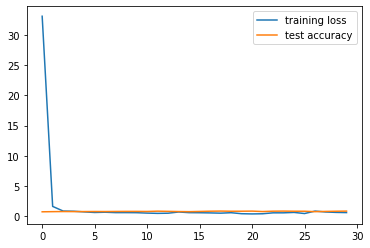

Test AUC: 0.889479


In [25]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label="training loss")
plt.plot(test_accs, label="test accuracy")
plt.legend()
plt.show()
# Test the model
test_auc = test(best_model, test_data)
print('Test AUC: {:.6f}'.format(test_auc))